# Repeat quasars

In [88]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [151]:
from astropy.table import join, hstack, Column, unique
from astropy.io import ascii

 ### Query the data via `bossquery` from the bossdata package:
 #### http://bossdata.readthedocs.org/en/latest/scripts.html#bossquery

#### BOSS 

Pipeline version number: export BOSS_REDUX_VERSION=v5_7_0

`bossquery --full --what 'PLATE,MJD,FIBER,THING_ID,RUN,RERUN,CAMCOL,FIELD,ID' --where 'CLASS="QSO" and ZWARNING=0 and Z_ERR>0 and RUN>0' --max-rows 100000 --save boss_qsos.dat`

#### DR13 (BOSS+SEQUELS)

Pipeline version number: export BOSS_REDUX_VERSION=v5_9_0

`bossquery --full --what 'PLATE,MJD,FIBER,THING_ID,RUN,RERUN,CAMCOL,FIELD,ID' --where 'CLASS="QSO" and ZWARNING=0 and Z_ERR>0 and EBOSS_TARGET1&4096>0' --max-rows 100000 --save dr13_qsos.dat` 

##### Note: This query return no rows

#### eBOSS 

Pipeline version number: export BOSS_REDUX_VERSION=v5_9_1

`bossquery --full --what 'PLATE,MJD,FIBER,THING_ID,RUN,RERUN,CAMCOL,FIELD,ID' --where 'CLASS="QSO" and ZWARNING=0 and Z_ERR>0 and EBOSS_TARGET1&4096>0' --max-rows 100000 --save eboss_qsos.dat`

In [147]:
boss = ascii.read('boss_qsos.dat')
eboss = ascii.read('eboss_qsos.dat', format='csv', delimiter=' ')

In [148]:
print 'eBOSS returned %d quasars' %len(eboss)
print 'BOSS returned %d quasars' %len(boss)

eBOSS returned 9952 quasars
BOSS returned 100000 quasars


In [113]:
#eboss has missing ID values
eboss['ID'].fill_value = -999

### Match quasars

In [149]:
overlap = join(eboss.filled(), boss, keys=('RUN','RERUN','CAMCOL','FIELD', 'ID'), join_type='inner', table_names=('E','B'))
overlap = overlap.group_by(('PLATE_E','MJD_E','FIBER_E'))
repeats = Table([overlap['PLATE_E'],overlap['MJD_E'],overlap['FIBER_E'],overlap['THING_ID_E'],overlap['PLATE_B'],overlap['MJD_B'],overlap['FIBER_B'],overlap['THING_ID_B']])

In [152]:
repeats

PLATE_E,MJD_E,FIBER_E,THING_ID_E,PLATE_B,MJD_B,FIBER_B,THING_ID_B
int64,int64,int64,int64,int64,int64,int64,int64
7818,56989,5,85118903,4229,55501,106,85234552
7818,56989,12,77873749,4230,55483,421,77960659
7818,56989,64,87887349,4229,55501,192,88013318
7818,56989,94,77865427,4229,55501,300,77952306
7818,56989,127,68298856,4229,55501,242,68334028
7818,56989,132,73003909,4229,55501,206,73067713
7818,56989,172,77863794,4229,55501,334,77950663
7818,56989,182,73005930,4229,55501,284,73069746
7818,56989,216,87883641,4229,55501,310,88009610


In [50]:
#repeats.write('eboss_boss_repeat_qsos.dat', format='ascii')

In [153]:
eboss_overlap = Table([repeats['PLATE_E'],repeats['MJD_E'],repeats['FIBER_E'],repeats['THING_ID_E']])
unique_eboss = unique(eboss_overlap)

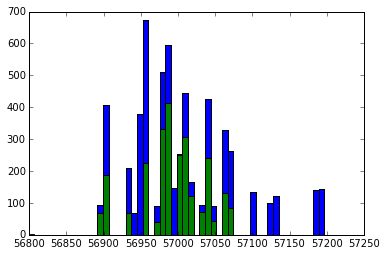

In [154]:
plt.figure()
plt.hist(eboss['MJD'], bins=np.linspace(56800, 57250, 60))
plt.hist(unique_eboss['MJD_E'], bins=np.linspace(56800, 57250, 60));

In [156]:
#Around 42% of eBOSS quasars are reobserved BOSS quasars (when overlap is performed over first 100,000 BOSS quasars)
float(len(unique_eboss))/len(eboss)

0.4215233118971061